In [1]:
import sys

sys.path.append('../../')

import numpy as np
import pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn import datasets
from dal_toolbox.models.ensemble import Ensemble, EnsembleOptimizer, train_one_epoch

/home/denis/miniconda3/envs/uncertainty_evaluation/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


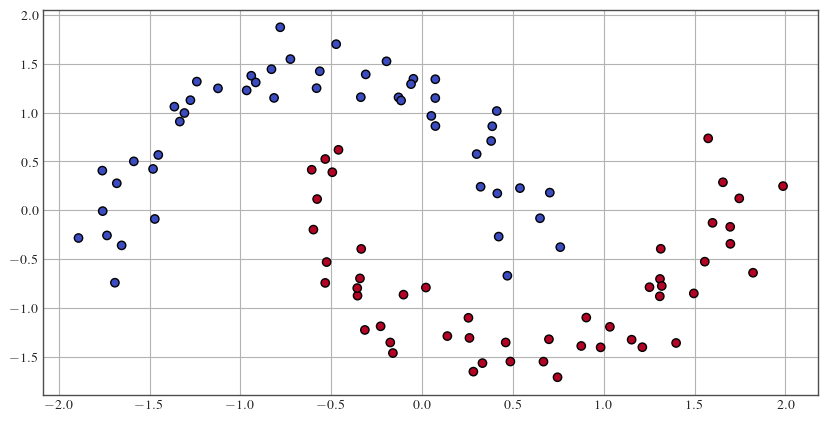

In [2]:
X, y = datasets.make_moons(100, noise=.1, random_state=42)
# X, y = datasets.make_circles(500, noise=.02)
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

train_ds = torch.utils.data.TensorDataset(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [3]:


class Net(nn.Module):
    def __init__(self,
                 num_classes: int,
                 dropout_rate: int = .2,
                 feature_dim: int = 128,
                 ):
        super().__init__()

        self.first = nn.Linear(2, feature_dim)
        self.first_dropout = nn.Dropout(dropout_rate)
        self.hidden = nn.Linear(feature_dim, feature_dim)
        self.hidden_dropout = nn.Dropout(dropout_rate)
        self.last = nn.Linear(feature_dim, num_classes)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.first(x))
        x = self.first_dropout(x)
        x = self.act(self.hidden(x))
        x = self.hidden_dropout(x)
        out = self.last(x)
        return out

    def mc_forward_impl(self, x):
        return self.forward(x)


In [4]:
@torch.no_grad()
def plot_contour(model, X, y, ax=None):
    model.eval()
    model.cpu()
    if ax:
        plt.sca(ax)
    domain = 5
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51))
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    logits = model.forward_sample(zz)
    probas = logits.softmax(-1)
    probas = probas.mean(0)
    zz = probas[:, 1].view(xx.shape)

    # plt.title(f"Ep {}")
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6))
    plt.colorbar()

Epoch [0] Model [0]  [0/1] eta: 0:00:00 loss: 0.6889 (0.6889) acc1: 50.0000 (50.0000) time: 0.5268 data: 0.0008 max mem: 1
Epoch [0] Model [0]  Total time: 0:00:00
Epoch [0] Model [1]  [0/1] eta: 0:00:00 loss: 0.6794 (0.6794) acc1: 68.0000 (68.0000) time: 0.0072 data: 0.0009 max mem: 1
Epoch [0] Model [1]  Total time: 0:00:00
Epoch [0] Model [2]  [0/1] eta: 0:00:00 loss: 0.6495 (0.6495) acc1: 76.0000 (76.0000) time: 0.0027 data: 0.0005 max mem: 1
Epoch [0] Model [2]  Total time: 0:00:00
Epoch [0] Model [3]  [0/1] eta: 0:00:00 loss: 0.6996 (0.6996) acc1: 44.0000 (44.0000) time: 0.0032 data: 0.0004 max mem: 2
Epoch [0] Model [3]  Total time: 0:00:00
Epoch [0] Model [4]  [0/1] eta: 0:00:00 loss: 0.7362 (0.7362) acc1: 22.0000 (22.0000) time: 0.0058 data: 0.0005 max mem: 3
Epoch [0] Model [4]  Total time: 0:00:00
Epoch [1] Model [0]  [0/1] eta: 0:00:00 loss: 1.6491 (1.6491) acc1: 86.0000 (86.0000) time: 0.0055 data: 0.0005 max mem: 3
Epoch [1] Model [0]  Total time: 0:00:00
Epoch [1] Model 

/home/denis/miniconda3/envs/uncertainty_evaluation/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809662/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


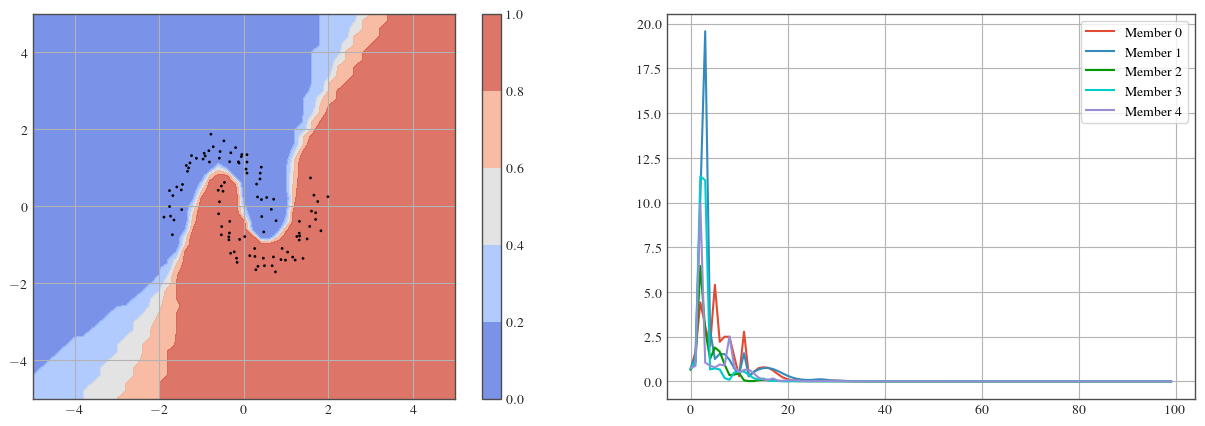

In [5]:
n_member = 5
dropout_rate = 0.0
optimizer_params = dict(
    lr=1e-1,
    weight_decay=0,
    # momentum=.9,
)
epochs = 100
torch.manual_seed(0)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)

model = Ensemble([Net(dropout_rate=dropout_rate, num_classes=2) for _ in range(n_member)])
optimizer = EnsembleOptimizer([torch.optim.AdamW(model.parameters(), **optimizer_params) for _ in range(n_member)])
criterion = nn.CrossEntropyLoss()
history = []
for i in range(epochs):
    train_stats = train_one_epoch(model, train_loader, criterion, optimizer, device='cuda', epoch=i)
    history.append(train_stats)

model.eval()
plt.figure(figsize=(15, 5))
plt.subplot(122)
for i in range(n_member):
    plt.plot([d[f'train_loss_model{i}'] for d in history], label=f'Member {i}')
plt.legend()
plot_contour(model, X, y, ax=plt.subplot(121))
plt.show()
